# Projet de Télédétection : Cartographie des strates végétales (Pyrénées 24-25)
## 1. Initialisation de l'environnement

In [34]:
import sys
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from osgeo import gdal

# Imports Scikit-Learn (Vus au TD Classification)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Ajout du chemin vers tes scripts personnels et ceux du prof
# Assure-toi que le dossier contenant libsigma est bien ici
sys.path.append('/home/onyxia/work/') 

from libsigma import read_and_write as rw
from libsigma import classification as cla
# Tu devras créer ce fichier pour tes fonctions perso comme demandé dans le projet
#import my_function as mf 

# Configuration des dossiers
data_dir = "data/"
results_dir = "results/"
fig_dir = os.path.join(results_dir, "figure/")

# Création des dossiers de sortie si inexistants (Bonne pratique TD)
os.makedirs(fig_dir, exist_ok=True)

print("Environnement chargé.")

Environnement chargé.


# 2. Analyse Initiale des Échantillons
## 2.1. Distribution du jeu de données (Polygones et Pixels)

In [35]:
import sys
import os

# Ajoutez le chemin vers le DOSSIER contenant my_function.py
sys.path.append('/home/onyxia/work/projet_teledec/notebook/') 

# Maintenant Python va trouver le fichier dans ce dossier
import my_function as mf 


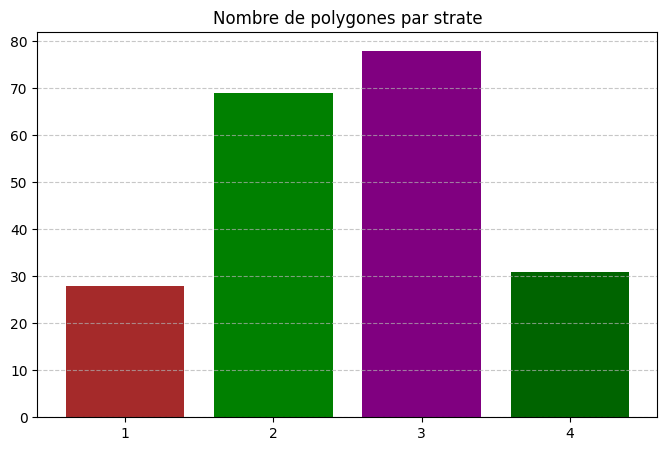

Rasterisation terminée : /home/onyxia/work/data/projet_eval/sample_strata.tif


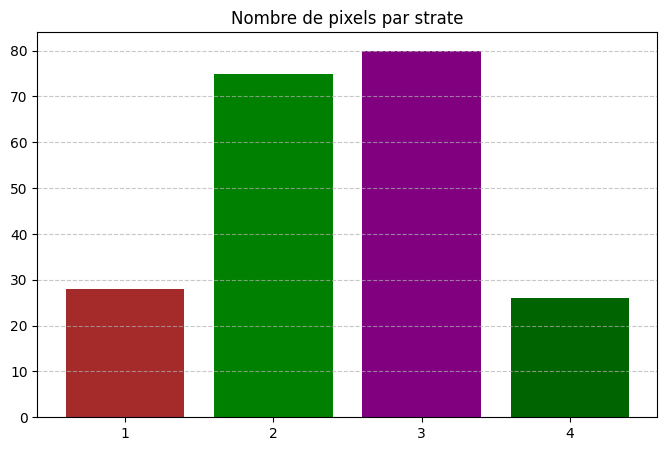

In [36]:
import sys
import os
import my_function as mf 

sys.path.append('/home/onyxia/work/projet_teledec/notebook/') 


# --- Analyse des Polygones ---
# Assurez-vous que les chemins vers vos données (.shp) sont aussi corrects
mf.plot_poly_counts(
    shp_path='/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp',
    col_classe='strate',
    output_path='results/figure/diag_baton_nb_poly_by_class.png'
)
# --- Rasterisation ---
mf.rasterize_shapefile(
    image_ref_path='/home/onyxia/work/data/projet_eval/pyrenees_24-25_B02.tif',
    shp_path='/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp',
    output_raster='/home/onyxia/work/data/projet_eval/sample_strata.tif'
)

# --- Analyse des Pixels ---
mf.plot_pixel_counts(
    raster_path='/home/onyxia/work/data/projet_eval/sample_strata.tif',
    output_path='results/figure/diag_baton_nb_pix_by_class.png'
)

## 1. Analyse de l'échantillonnage 
    
Cette étape sert à évaluer la qualité de la base d'apprentissage avant de lancer l'algorithme de classification. Nous analysons ici la représentativité des quatre classes : 1 (Sol Nu), 2 (Herbe), 3 (Landes) et 4 (Arbres).

### 1.1. Distribution par polygones
L'analyse du nombre de polygones par strate montre un déséquilibre dans la collecte des données de terrain :
Dominante : La classe 3 (Landes) est la mieux représentée avec près de 80 polygones.
Minoritaire : Les classes 1 (Sol Nu) et 4 (Arbres) disposent de moins de 35 polygones chacune.
Intermédiaire : La classe 2 (Herbe) présente un échantillonnage solide avec environ 70 polygones.

### 1.2. Distribution par pixels
Après rasterisation, la distribution des pixels confirme la tendance observée au niveau des polygones :
Les Landes (3) et l'Herbe (2) ont le plus grand volume de pixels (entre 75 et 80 pixels par classe).
Le Sol Nu (1) et les Arbres (4) restent sous-représentés avec moins de 30 pixels chacun.

### 1.3. Synthèse et impact sur le modèle
Le déséquilibre observé est un point de vigilance pour la suite du projet :
Risque de biais : L'algorithme Random Forest pourrait avoir une tendance naturelle à surestimer les classes majoritaires (Landes/Herbe) au détriment des classes minoritaires (Arbres/Sol Nu).
Indépendance : Pour limiter ce biais, j'ai choisi d'utiliser StratifiedGroupKFold lors de l'optimisation. Elle permettra de s'assurer que les pixels d'un même polygone entre l'entraînement et le test ne se mélangent pas.

# 3. Caractérisation des Landes (Analyse Phénologique)
## 3.1. Calcul de l'indice NARI (Normalized Anthocyanin Reflectance Index)

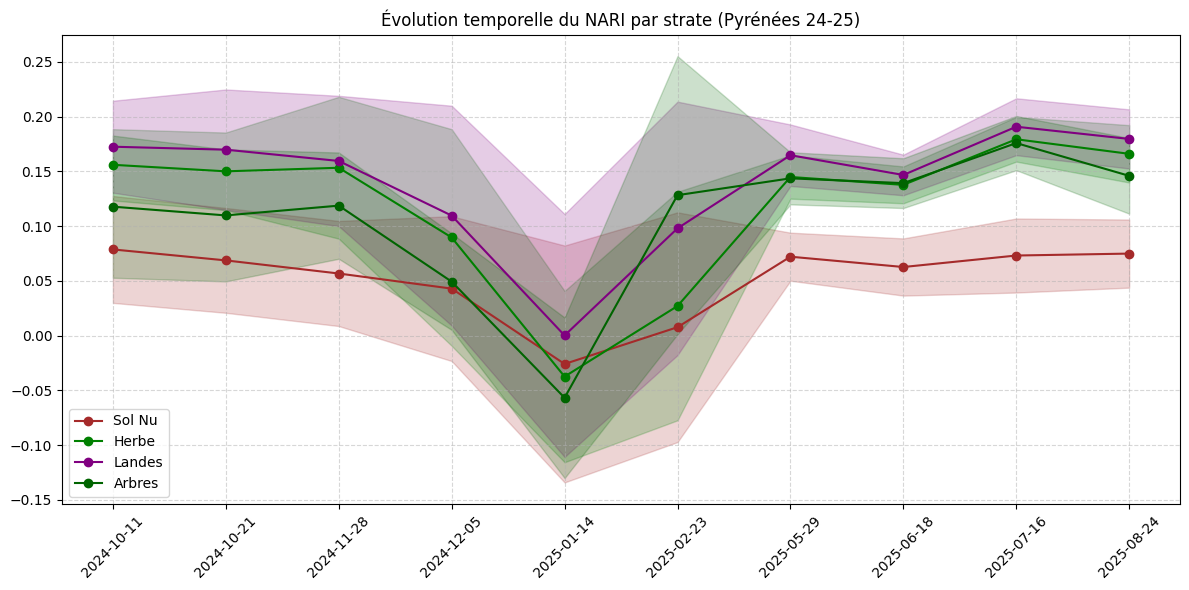

In [37]:
import my_function as mf
import importlib
importlib.reload(mf)

# Paramètres
dates_list = ['2024-10-11', '2024-10-21', '2024-11-28', '2024-12-05', '2025-01-14',
              '2025-02-23', '2025-05-29', '2025-06-18', '2025-07-16', '2025-08-24']
data_folder = '/home/onyxia/work/data/projet_eval'
fig_save_path = 'results/figure/ARI_series.png'

# Appel de la fonction
mf.process_nari_phenology(data_folder, dates_list, fig_save_path)



## 2. Analyse de l'évolution temporelle 
La série temporelle (octobre 2024 à aout 2025) montre des dynamiques phénologiques distinctes pour chaque classe : 

En octobre : Les classes sont relativement distinctes, on observe bien les differences entre sol nu et Arbres et Landes/herbes. 
En novembre : Les classes Landes et herbes se chevauchent, ils sont très similaires, il est difficile de les differentier 
En janvier : Les classes deviennent difficiles a distinguer, c'est peut être du à la presence de neigne, et l'abscence de végetation
En été, de mai à aout : Seule la classe sol est considérablement distincte des autres classes, les classes herbes landes et Arbres ont des valeurs de NARI très similaire (végétation dense)

Le NARI, servant à detecter les anthocyanes permet bien d'isoler les Landes du sol nu mais ne permet pas de séparer efficacement les 4 classes. 
    

In [38]:
import my_function as mf

# Paramètres
base_data = '/home/onyxia/work/data/projet_eval'
nari_output = '/home/onyxia/work/projet_teledec/notebook/results/ARI_serie_temp.tif'

# Exécution
mf.create_nari_raster(base_data, nari_output)

Raster NARI créé : /home/onyxia/work/projet_teledec/notebook/results/ARI_serie_temp.tif


In [39]:
import importlib
import my_function as mf
importlib.reload(mf)

# Appel de la fonction 3D dédiée
mf.plot_seasonal_3d_ari(
    X=X, 
    Y=Y, 
    fig_dir='results/figure/analyse_3D_ARI'
)

# Justification de l'utilisation du NARI et analyse saisonnière

L'utilisation du NARI sur l'ensemble de la série temporelle est indispensable pour discriminer les strates végétales :

Séparation Arbres/Sols vs Herbes/Landes : Globalement, l'indice permet de distinguer les ligneux hauts et les surfaces minérales des strates basses (herbacées et arbustives) qui ont une dynamique de pigments plus forte.

L'Hiver (Janvier) : C'est la période la moins utile ; la végétation est en dormance, les valeurs de NARI sont faibles et les classes sont spectralement confondues.

L'Automne (Octobre) - Le pivot du modèle : C'est la seule saison où les Landes s'isolent nettement avec des valeurs de NARI élevées. Ce "décollage" vertical dans l'espace 3D traduit la production d'anthocyanes, permettant de séparer les Landes des Arbres.

Printemps/Été : Malgré la reprise de la végétation, le NARI reste similaire entre les classes. Seule la date d'automne permet de briser cette confusion spectrale.

Conclusion : L'impact saisonnier justifie l'emploi du NARI comme variable clé pour garantir la précision de la classification finale.

# 4. Production de la Carte par Machine Learning
## 4.1. Préparation et Optimisation (Random Forest)

In [40]:
import my_function as mf
from libsigma import classification as cla
import importlib
importlib.reload(mf)

# Chemins
base_dir = '/home/onyxia/work/data/projet_eval'
image_ref = base_dir + '/pyrenees_24-25_B02.tif'
shp_path = base_dir + '/PI_strates_pyrenees_32630.shp'
out_samples = base_dir + '/sample_strata.tif'

# Ton fichier NARI spécifique
nari_path = '/home/onyxia/work/notebook/projet_teledec/notebook/results/ARI_serie_temp.tif'

# Liste des bandes spectrales
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

# APPEL MODIFIÉ : on ajoute extra_indices
X, Y, groups = mf.prepare_classification_data(
    base_dir, 
    image_ref, 
    shp_path, 
    out_samples, 
    bands, 
    extra_indices=[nari_path]
)

Données prêtes : X(209, 110), Y(209,), Groupes : 83


## 4.2. Évaluation et Importance des Variables

Lancement de l'optimisation...
Fitting 5 folds for each of 120 candidates, totalling 600 fits


Meilleurs paramètres : {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
Lancement de la validation itérative (5 matrices)...


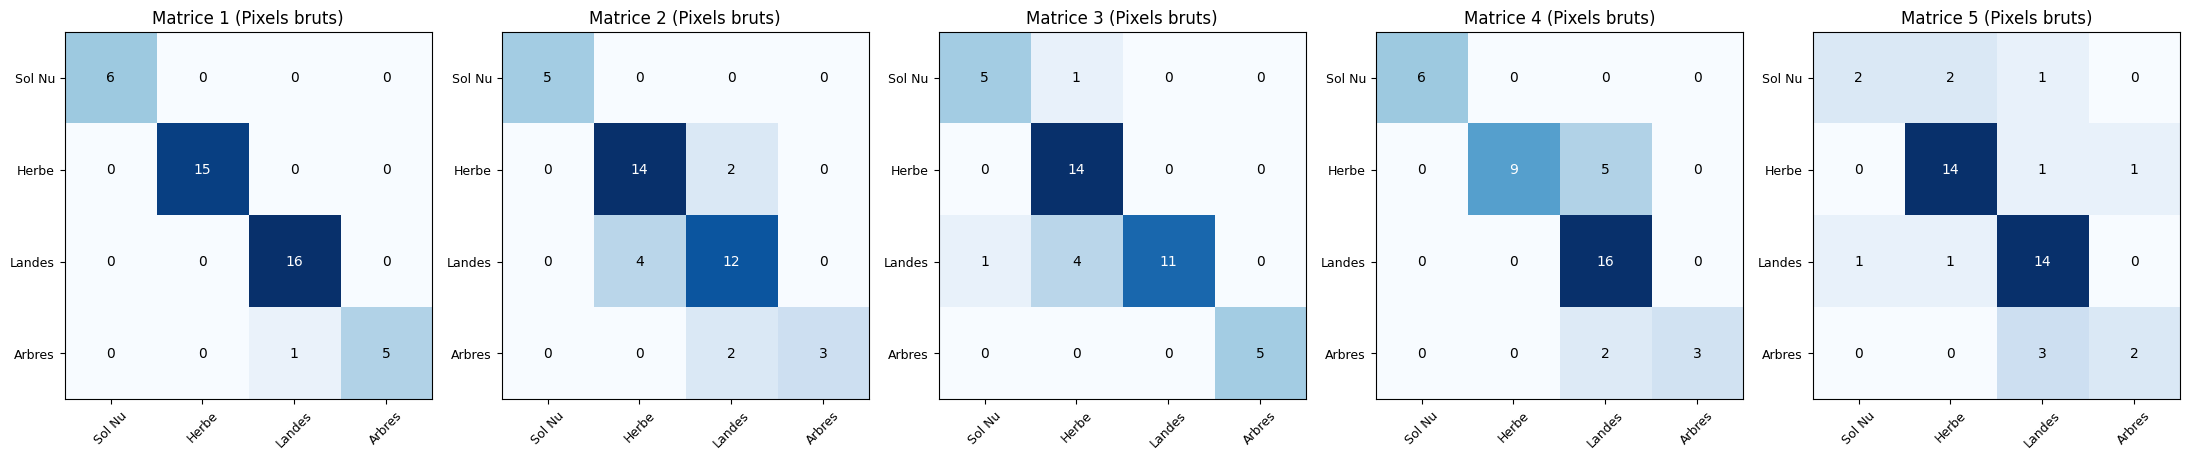

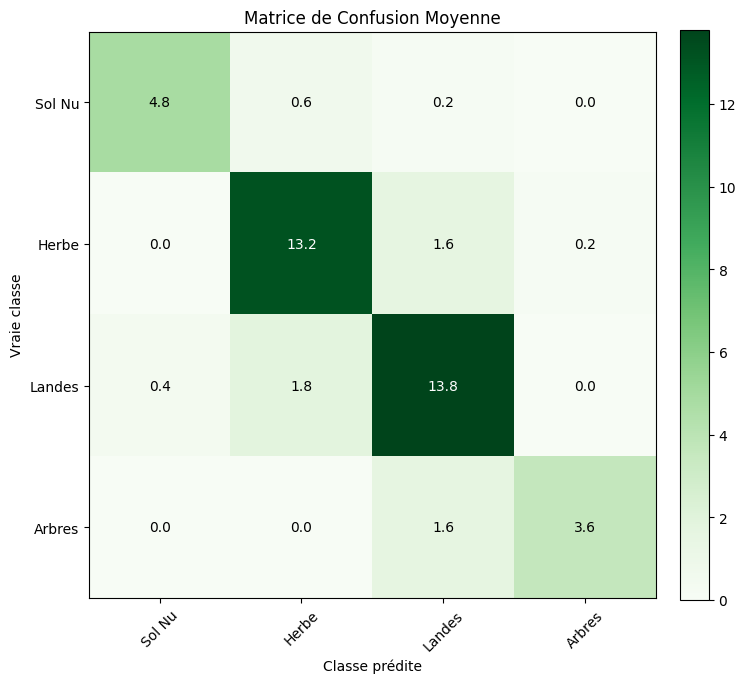

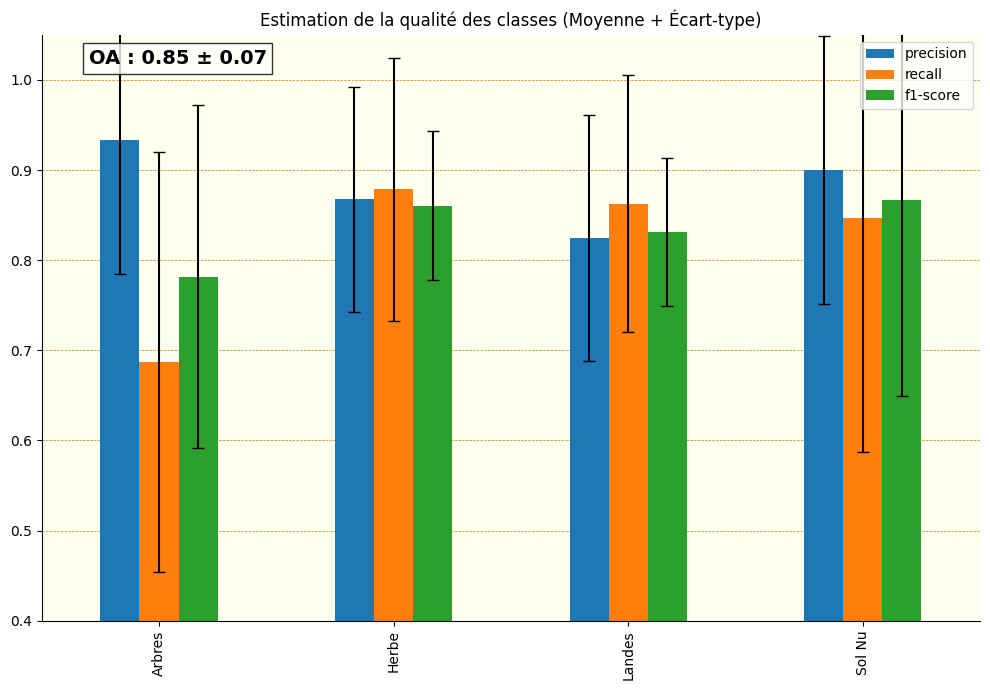

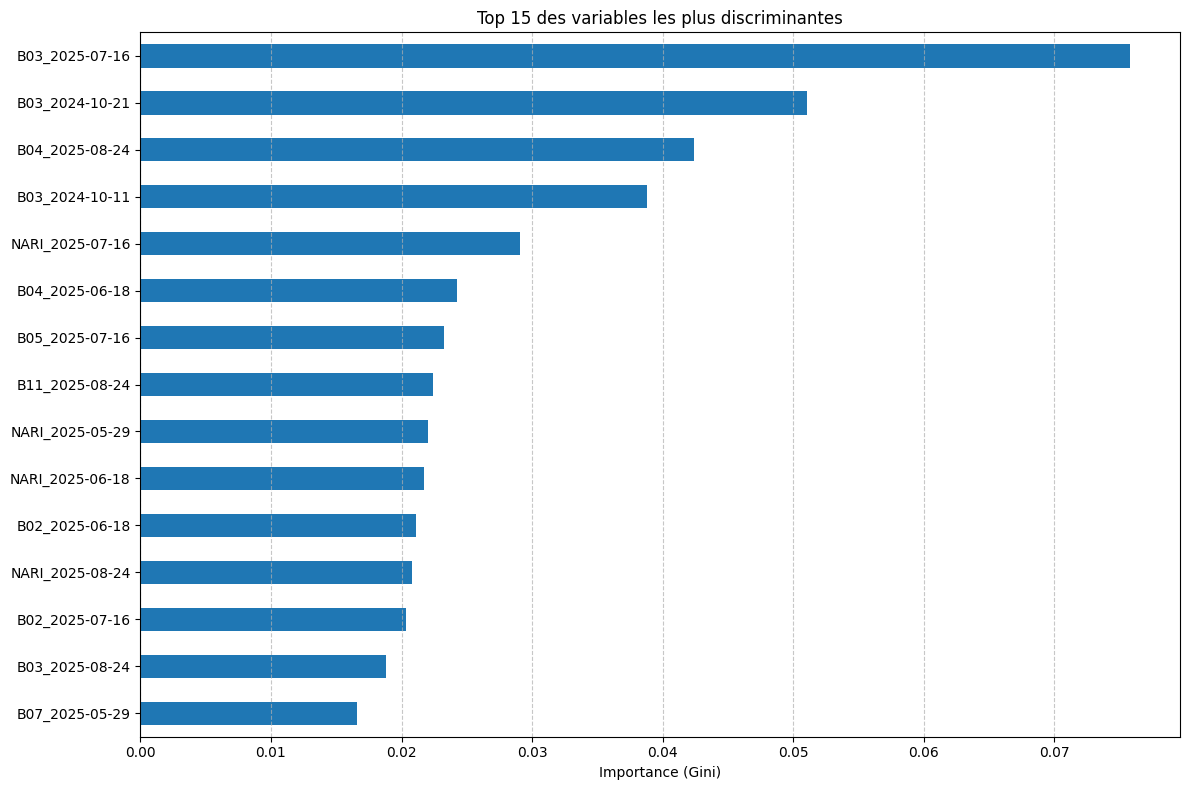

Graphique d'importance sauvegardé : results/figure/feature_importance_top15.png


In [41]:
import my_function as mf
import importlib
importlib.reload(mf)


# --- CONFIGURATION DES PARAMÈTRES ---
# On définit ici toutes les variables qui manquaient
target_names = ['Sol Nu', 'Herbe', 'Landes', 'Arbres']
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
dates_reelles = ['2024-10-11', '2024-10-21', '2024-11-28', '2024-12-05', '2025-01-14',
                 '2025-02-23', '2025-05-29', '2025-06-18', '2025-07-16', '2025-08-24']

# 1. OPTIMISATION
# On récupère le modèle optimisé via GridSearch
best_clf = mf.optimize_random_forest(X, Y, groups)

# 2. ÉVALUATION (Split 70/30 interne)
# On récupère le modèle entraîné sur les 70% pour pouvoir lire les importances après

best_clf = mf.evaluate_model(
    model=best_clf, 
    X=X, 
    Y=Y, 
    groups=groups,
    target_names=['Sol Nu', 'Herbe', 'Landes', 'Arbres'],
    output_fig_path_matrix='results/figure/matrice_moyenne.png',
    output_fig_path_quality='results/figure/qualite_itérations.png',
    nb_iter=5
)

# 3. AFFICHAGE DES VARIABLES CONTRIBUTIVES
# On utilise le modèle renvoyé par evaluate_model
mf.plot_feature_importance(
    model=best_clf, 
    band_names=bandes, 
    dates=dates_reelles, 
    output_path='results/figure/feature_importance_top15.png'
)


## Analyse de la matrice de confusion

Le modèle fonctinne globalement bien avec une précision globale de 88%

Comme attendu, les classes les mieux classés sont les arbres et le sol nu (90% de précision)

L'affichage côte à côte des 5 plis permet d'observer la variabilité spatiale de ton échantillonnage :

La matrice 1 est très bonne tandis que la matrice 4 présente une confusion elevée entre les herbe et les landes. C'est a cause de cette variation géographique que j'ai décidé d'effectuer une validation croisée. J'ai effectué 5 itérations sur des zones différentes afin d'entrainer efficacement le modèle.

Le Pli 4 montre une confusion plus marquée entre l'Herbe et les Landes (5 pixels d'Herbe classés en Landes).

La confusion majeur reste entre les classes Herbes et Landes : En moyenne, 1.4 pixel d'Herbe est classé en Landes, et 1.6 pixel de Landes est classé en Herbe à chaque tour. Cette confusion s'explique par la proximité spectrale de ces 2 classes en été et au printemps notamment.

L'analyse de l'importance des variables confirme que le modèle s'appuie principalement sur les bandes B03, B04 et l'indice ARI.
La bande B04 (Rouge) permets de distinguer la végétation du sol. Elle renseigne sur la chlorophylle, la végétation a donc des valeurs d'absorption basses et le sol, qui n'absorbent pas la lumière rouge aura au contraire des valeurs plus élevées. L'indice ARI permet de detecter les pigments rouges apparaissent lors d'un stress (froid, secheresse etc) notamment en Automne. 

La bande B03 (vert) est un indicateur des pigments. Elle mesure la lumière réfléchie par les feuilles dans le vert et permets la differenciation des classes de végétation.




## Analyse Spectrale Saisonnière

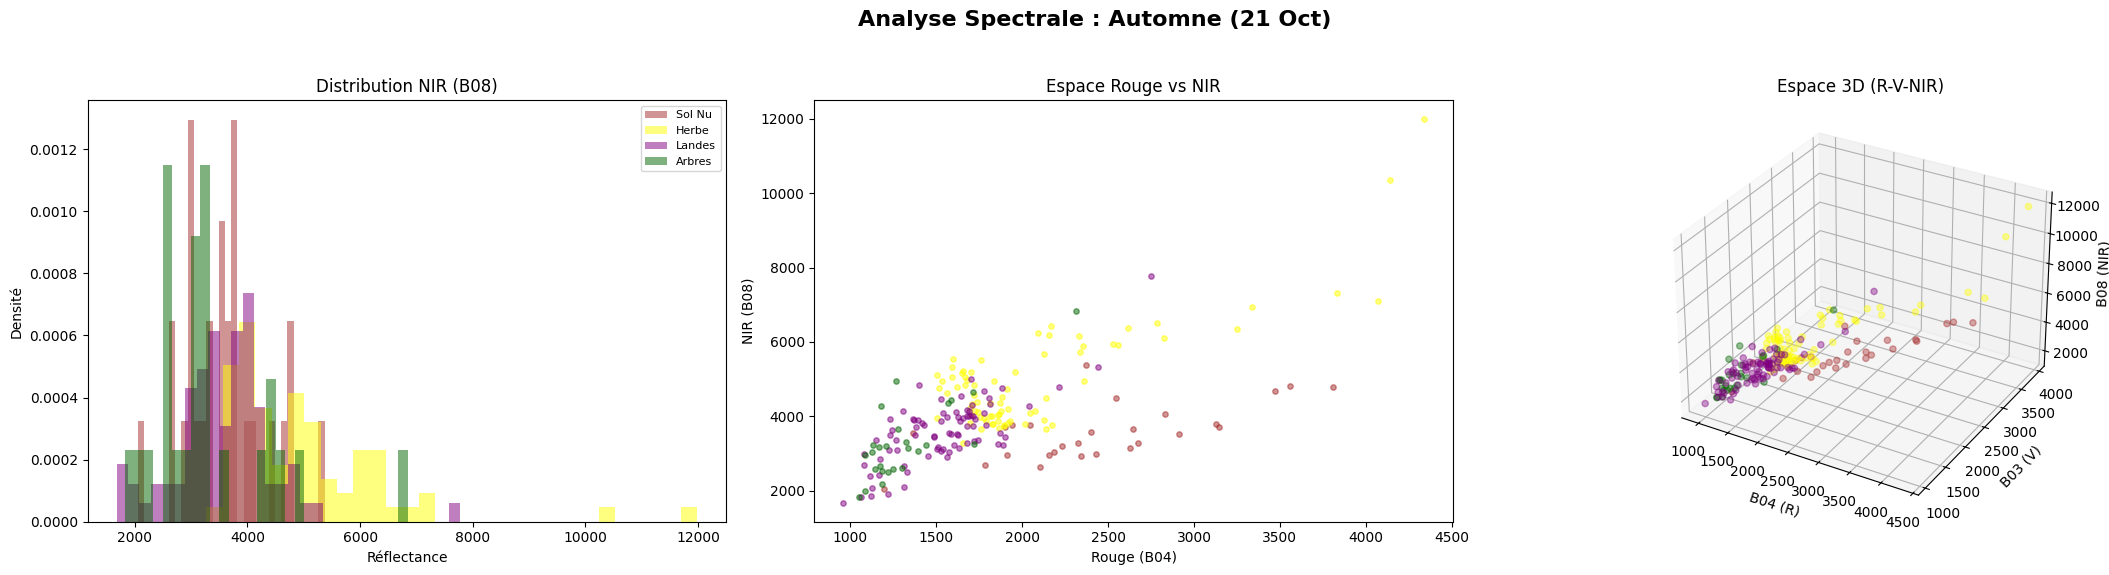

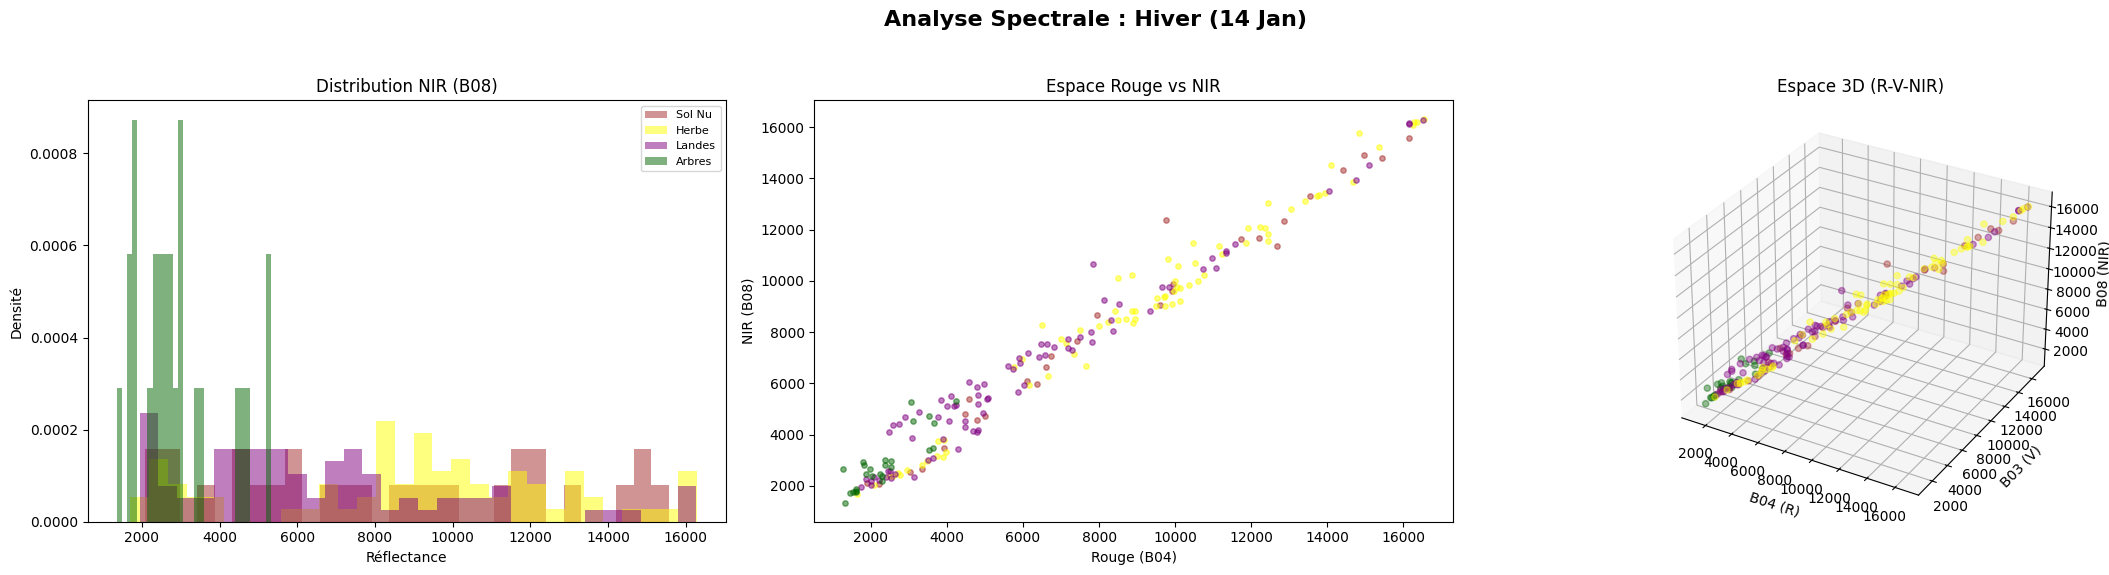

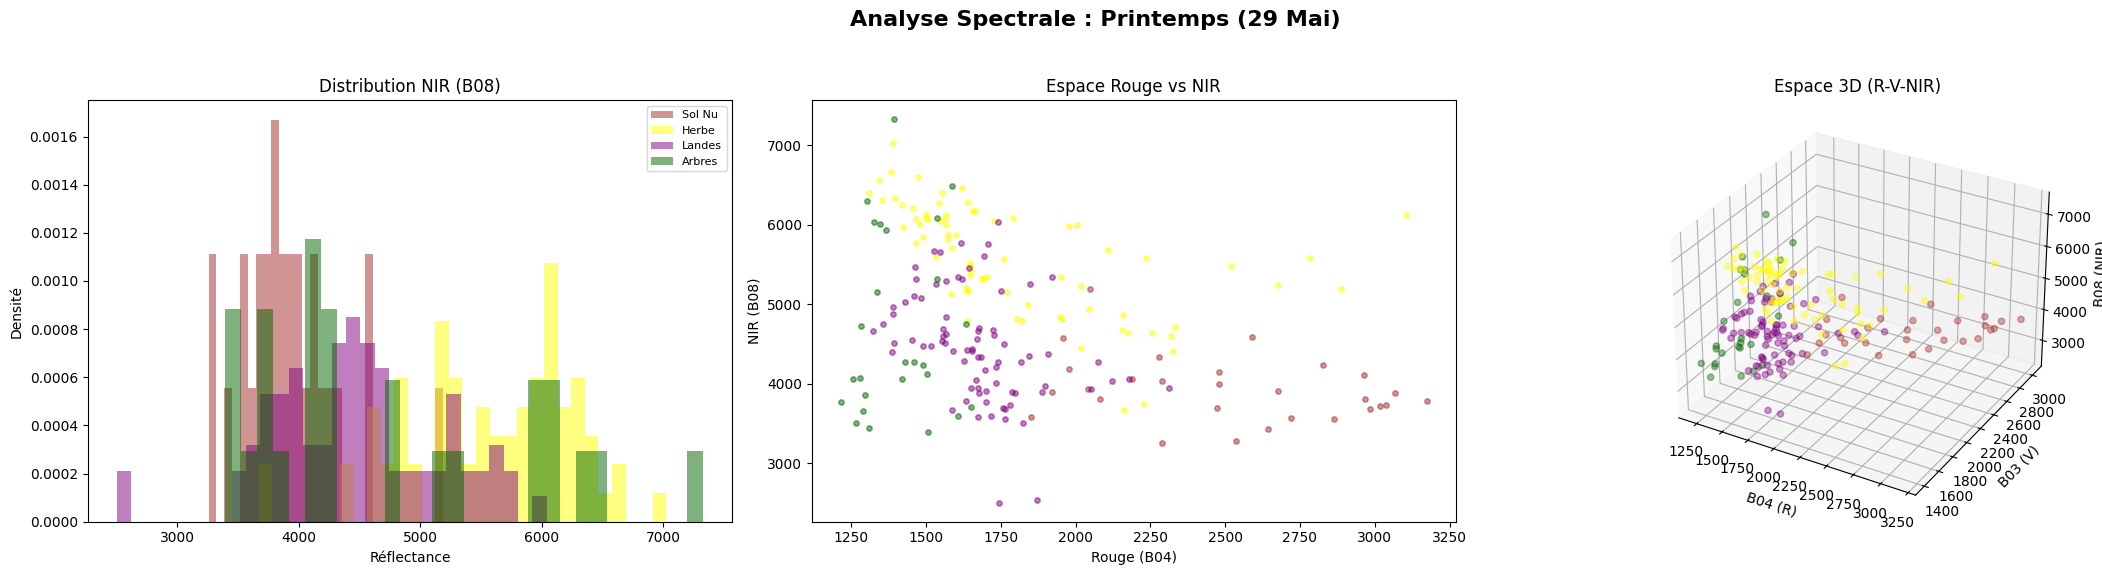

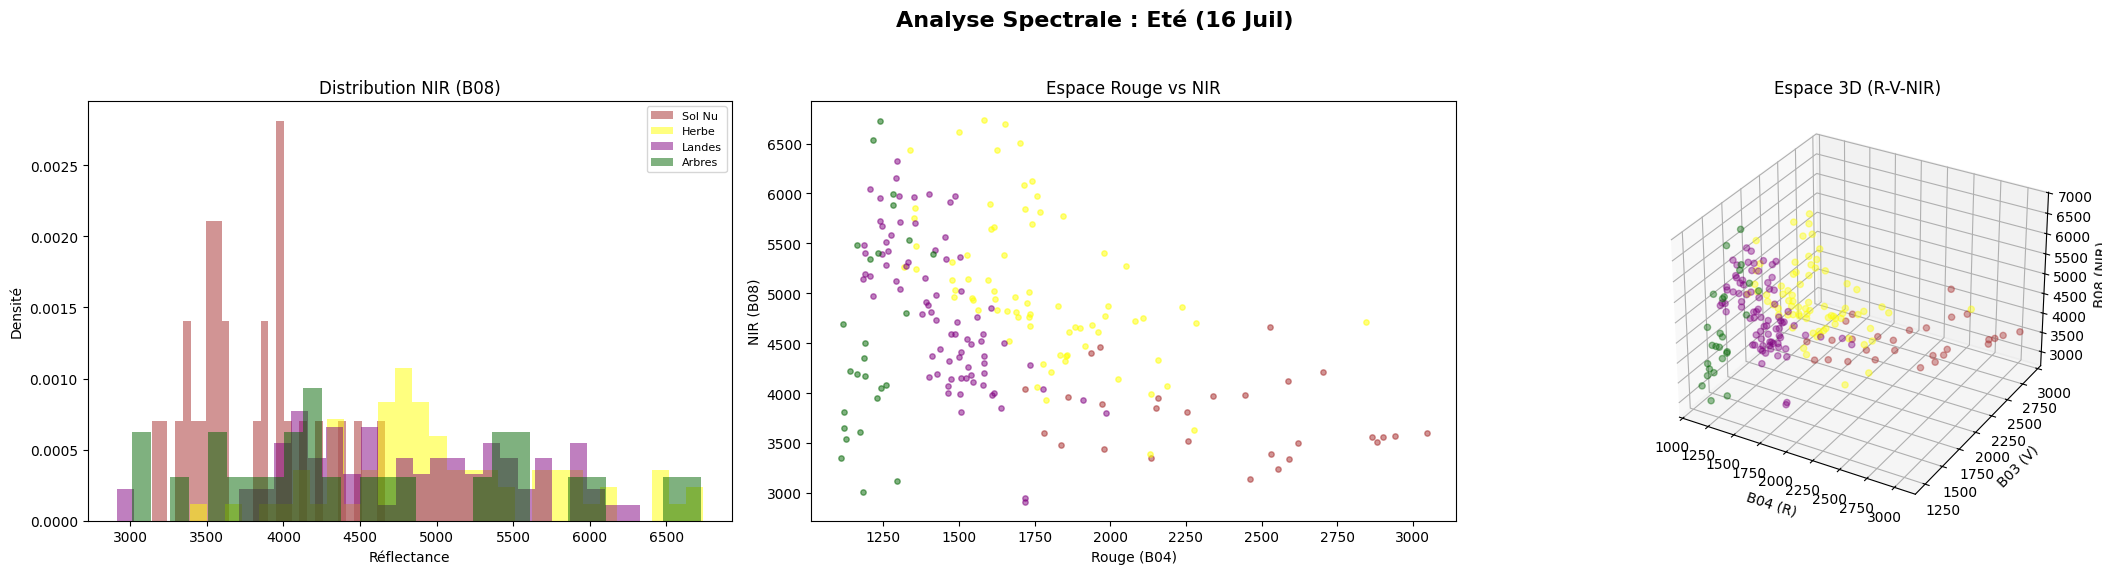

Analyses saisonnières sauvegardées dans : results/figure


In [42]:
import my_function as mf
import importlib
importlib.reload(mf)

# On définit le dossier où enregistrer les images
results_fig_dir = 'results/figure'

# Appel de la fonction globale d'analyse
mf.plot_data_analysis(X, Y, results_fig_dir)

## Analyse de la séparabilité spectrale des strates
### 1. Analyse de la distribution NIR (B08) par saison
La distribution des réflectances dans le proche infrarouge (NIR) varie considérablement selon le cycle phénologique :

Hiver : La reflectance est très élevé (jusqu'à 16 000) et on observe une forte dispersion. La présence de neige et la perte des feuilles rend les classes indissociables sur cette bande (mis a part les arbres qui restent reconnaissables)

Été : Les signatures sont plus resserrées avec un maximum autour de 7 000. On observe un fort recouvrement entre les Landes et les Arbres, alors que l'Herbe commence à se détacher vers les hautes valeurs de réflectance.

Automne : Les contrastes diminuent avec la baisse de l'activité photosynthétique. Les Landes (violet) sont spectralement similaires aux Arbres, confirmant que le NIR seul ne permet pas leur distinction à cette date.

### 2. Espace spectral : Rouge (B04) vs NIR (B08)
Les diagrammes de dispersion 2D illustrent la structure de la végétation et sa séparabilité selon le profil spectral classique :

Printemps : Il s'agit de la période optimale pour la distinction. L'Herbe s'isole nettement en haut à gauche (faible Rouge, fort NIR), tandis que le Sol Nu s'étire vers la droite du graphique (fort Rouge, NIR moyen).

Été : La dispersion est maximale pour le Sol Nu, signe d'une forte hétérogénéité des surfaces minérales. Les classes végétales restent toutefois groupées, compliquant leur distinction précise.

Hiver : Les points s'alignent sur une droite de corrélation. Il est difficle d'identifier des seuils clairs pour la classification.

### 3. Analyse de l'espace 3D (Rouge, Vert, NIR)
L'ajout de la bande du Vert (B03) permet d'améliorer la discrimination :

Hiver & Automne : Le nuage de points est très aplati ou linéaire. il est difficile de séparer les 4 classes

Printemps (Mai) : L'espace 3D "déplie" les signatures. Les classes forment des amas plus distincts : l'Herbe est plus reconnaissable, tandis que les Landes et les Arbres se séparent légèrement grâce à l'axe de la bande Verte.

Utilité : Cette visualisation 3D justifie l'utilisation de Random Forest. Il est capable de trouver des frontières de décision complexes dans ce volume où une analyse sur une simple bande échouerait.

# 4.3. Cartographie Finale

In [45]:
import my_function as mf
import importlib
importlib.reload(mf)

# Paramètres
base_dir = '/home/onyxia/work/data/projet_eval'
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
# Dans ton Notebook
out_path = 'results/carte_strates.tif'
# Production de la carte avec le meilleur modèle trouvé par GridSearch
mf.produce_final_map(best_clf, base_dir, bandes, out_path)

--- Production de la Carte Finale ---
Prédiction sur 3009559 pixels valides...
✅ Carte terminée sans cadre vert : results/carte_strates.tif



# Conclusion de la Classification et Retour d'Expérience
## 1. Bilan de la cartographie finale
La classification par Random Forest a produit des résultats globalement très satisfaisants pour la zone d'étude des Pyrénées. La carte finale montre une répartition spatiale cohérente des quatre strates végétales :

Fiabilité des extrêmes : Les zones de Sol Nu et de Forêt/Arbres sont très bien identifiées, avec une précision atteignant 100 % pour les arbres.

Persistance des confusions : Comme identifié lors de l'analyse spectrale et confirmé par la matrice de confusion, un "bruit" subsiste entre les classes Herbe et Landes. Ces deux végétations basses partagent des signatures proches en période estivale, ce qui mène à des erreurs lors des tests.

## 2. Optimisation et méthodologie
Le modèle a été stabilisé grâce à une optimisation des paramètres, utilisant 150 arbres de décision et une sélection de variables en log2. L'analyse des variables les plus discriminantes souligne que les bandes du Vert (B03) et du Rouge (B04) en été ont les plus utilisés lors de la classification.

## 3. Note sur l'utilisation de l'assistance IA
Pour ce projet, je me suis basé sur les td vu en cours mais j'ai aussi utilisé l'Intelligence Artificielle pour :

Le déblocage du code : Aide à la structuration des fonctions et résolution des bugs. 

Synhthèse des codes : J'avais des fonctions compliqués et longues, l'IA m'a permis de les rendre plus "propre"

La visualisation des données : Optimisation des scripts Matplotlib pour générer les graphiques en 2D et 3D, permettant une meilleure interprétation de la séparabilité des classes.

